In [1]:
import os
import sys
import glob
import copy
import datetime
import platform

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm_notebook

In [2]:
if 'Windows' in platform.platform() and '8.1' in platform.release():
    _ = "C:\\Users\\Andrey\\YandexDisk\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    DELIMITER = "\\"

elif 'Windows' in platform.platform() and '7' in platform.release():
    _ = "E:\\Disk.Yandex\\3.Programing\\"
    DATA_DIR = "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    DELIMITER = "\\"

elif 'Windows' in platform.platform() and '10' in platform.release():
    _ = "F:\\YandexDisk\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    ALL_DATA = "F:\\YandexDisk\\1.Работа\\Результаты обработки\\"
    DELIMITER = "\\"    
    
elif 'Linux' in platform.platform() and '4.4.0' in platform.release():
    _ = "/home/andr/Yandex.Disk/3.Programing/"
    DATA_DIR = _ + "work/PulseViewer/pulsarsData/"
    PATTERN_DIR = _ + "/work/PulseViewer/frame_of_AP/patterns/"
    PACK_DIR = _ + "myPacks/"
    ALL_DATA = "/home/andr/Yandex.Disk/1.Работа/Результаты обработки/"
    DELIMITER = "/"
    
else:
    print('unknown system', platform.platform(), platform.release())

sys.path.append(PACK_DIR)
from PRAO import *

In [3]:
pulsar_name = '1112+50'
global_dir_pulsar = ALL_DATA + pulsar_name + os.sep

In [4]:
global_files = sorted(glob.glob(global_dir_pulsar + '20*' + os.sep + '*' + os.sep + '*_profiles.txt'))

In [5]:
sessons_obs = pd.DataFrame(columns=[
    'Date', 
    'Session'
])

In [6]:
gp_pulsar = pd.DataFrame(columns=[
    'Date', 
    'Time start', 
    'Tay, ms',
    'Period, s',
    'Numpointwin, point',
    'Numpulse, a.u.',
    'Median, adc u',
    'STD, adc u',
    'File name',
    'Count of GP, u',
    'Num pulse',
    'point of gp, point',
    'amp of gp, adc u',
    'W50, point',
    'W10, point',
    'path plot',
    
])

MemoryError: 

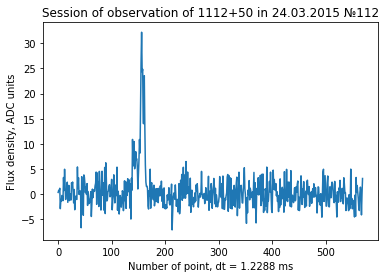

In [8]:
idx = 0
idx_obs = 0
for file in tqdm_notebook(global_files):
    try:
        head, main_profile, data_pulses, back = read_profiles(file)
        pattern = np.loadtxt(
            PATTERN_DIR
            + DELIMITER
            + head['name']
            + '_'
            + head['tay']
            + '.csv',  skiprows=4)
        
        l_edge, r_edge = edgesOprofile(main_profile, pattern)
        #thres = 30*np.max(main_profile)
        
        if quality_data(main_profile, l_edge, r_edge):
            sessons_obs.loc[idx_obs] = [
                head['date'],
                1
            ]
            idx_obs += 1
            
            for index, pulse in enumerate(data_pulses):
                noise = np.append(pulse[:l_edge], pulse[r_edge:])
                if (np.max(pulse) >= 10*np.std(noise)) and (l_edge <= np.argmax(pulse) <= r_edge):
                    
                    w10, _, _ =  width_of_pulse(pulse, 0.1)
                    w50, _, _ = width_of_pulse(pulse, 0.5)
                    
                    path_pulse = (
                        './gp_plot_pulsar/'
                        + head['date']
                        + '_plot_'
                        + head['name']
                        + '_'
                        + str(index)
                        + '.png')
                    
                    plt.close()
                    plt.title(
                        'Session of observation of '
                        + pulsar_name
                        +
                        ' in '
                        + head['date']
                        + ' '
                        + '№'
                        + str(index))
                    
                    plt.xlabel('Number of point, dt = ' + head['tay']  + ' ' + 'ms')
                    plt.ylabel('Flux density, ADC units')
                    plt.plot(pulse)
                    plt.savefig(path_pulse, format='png', dpi=100)
                    
                    gp_pulsar.loc[idx] = [
                        head['date'],
                        head['time'],
                        head['tay'],
                        head['period'],
                        head['numpointwin'],
                        head['numpuls'],
                        np.mean(back),
                        np.std(np.append(pulse[:l_edge], pulse[r_edge:])),
                        os.path.basename(file),
                        1,
                        index,
                        np.argmax(pulse),
                        np.max(pulse),
                        w50,
                        w10,
                        path_pulse
                    ]
                    idx += 1
                    
                else:
                    continue
        else:
            continue
            
    except ValueError:
        with open('valerr_' + pulsar_name + '.log', 'a') as f:
            f.write(os.path.basename(file))
            f.write('\n')
    except OSError:
        with open('oserr_' + pulsar_name + '.log', 'a') as f:
            f.write(os.path.basename(file))
            f.write('\n')

In [7]:
plt.close()
plt.plot(main_profile)
plt.show()

NameError: name 'main_profile' is not defined

In [8]:
head, main_profile, data_pulses, back = read_profiles(global_files[0]) 
non_cor_data = []
    
for pulse, backg in zip(data_pulses, back):
    non_cor_data.append(pulse + backg)
obser = np.hstack(non_cor_data)
med_flux = np.median(obser)
std_obs = np.std(obser)

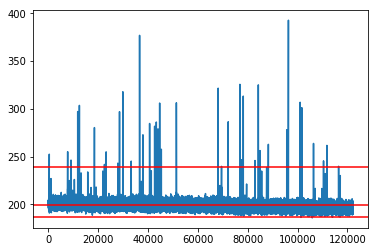

In [14]:
plt.close()
plt.plot(obser)
plt.axhline(med_flux, color='r')
plt.axhline(med_flux + 10*std_obs, color='red')
plt.axhline(med_flux - 3*std_obs, color='red')
plt.show()

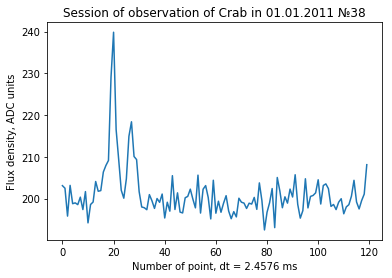

In [16]:
test_obser = copy(obser)
    
i = 0
while np.max(test_obser) >= (10*std_obs + med_flux):
    x_max = np.argmax(test_obser)
    pulse = test_obser[x_max - 20: x_max + 100]
        
    path_pulse = './gp_plot_pulsar/' + head['date'] + '_plot_'+ head['name'] + '_'+ str(i)  + '.png'
    plt.close()
    plt.title('Session of observation of Crab in ' + head['date'] + ' ' + '№' + str(i))
    plt.xlabel('Number of point, dt = ' + head['tay']  + ' ' + 'ms')
    plt.ylabel('Flux density, ADC units')
    plt.plot(pulse)
    plt.savefig(path_pulse, format='png', dpi=100)
    i += 1
    w10, _, _ =  width_of_pulse(pulse, 0.1)
    w50, _, _ = width_of_pulse(pulse, 0.5)
    amp = max(pulse)
    medias = np.full(len(pulse), med_flux)
    test_obser[x_max - 20: x_max + 100] = medias

In [17]:
i

39

In [13]:
gp_pulsar.to_csv(pulsar_name + '_gp_kaz_10.csv',  sep='\t', header=True, index=False)

In [14]:
sessons_obs.to_csv(pulsar_name + '_obs_kaz.csv',  sep='\t', header=True, index=False)